# Machine Learning in Python - Project 1

Due Friday, March 6th by 5 pm.

## 1. Setup

### 1.1 Libraries

In [1]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (15,8)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pkg_resources
if pkg_resources.get_distribution("scikit-learn").version != '0.22.1':
    !conda install --yes scikit-learn

Solving environment: done

# All requested packages already installed.



### 1.2 Data

In [3]:
sales = pd.read_csv("sales.csv")
sales_test = pd.read_csv("sales_test.csv")

## 2. Exploratory Data Analysis and Preprocessing

*Include a discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up.*

*In this section you should also implement and describe any preprocessing / transformations of the features. Hint - you should not be modeling this data without transforming some of the features, e.g. modeling sale price directly is not a good idea.*

In [4]:
sales.head()

,sale_price,year_sold,year_built,lot_area,basement_area,living_area,full_bath,half_bath,bedroom,garage_cars,garage_area,ac,zoning,neighborhood,quality,condition
0,244000,2010,1968,11160,2110,2110,2,1,3,2,522,Y,Residential_Low_Density,nb_07,good,average
1,189900,2010,1997,13830,928,1629,2,1,3,2,482,Y,Residential_Low_Density,nb_22,average,average
2,191500,2010,1992,5005,1280,1280,2,0,2,2,506,Y,Residential_Low_Density,nb_10,good,average
3,236500,2010,1995,5389,1595,1616,2,0,2,2,608,Y,Residential_Low_Density,nb_10,good,average
4,189000,2010,1999,7500,994,1804,2,1,3,2,442,Y,Residential_Low_Density,nb_22,good,average


In [5]:
# Functions to convert the categorical values of the zoning data, quality data, and condition data into integer form
# This is to make the data easier to read
def rat_to_int(arg, df):
    for i in range(len(df)):
        if df[arg][i] == 'poor':
            df[arg][i] = 1
        elif df[arg][i] == 'fair':
            df[arg][i] = 2   
        elif df[arg][i] == 'average':
            df[arg][i] = 3
        elif df[arg][i] == 'good':
            df[arg][i] = 4
        elif df[arg][i] == 'excellent':
            df[arg][i] = 5
            
def zone_to_int(arg, df):
    for i in range(len(df)):
        if df[arg][i] == 'Residential_Low_Density':
            df[arg][i] = 1
        elif df[arg][i] == 'Residential_Medium_Density':
            df[arg][i] = 2   
        elif df[arg][i] == 'Residential_High_Density':
            df[arg][i] = 3

# This function is to convert the air conditioning data column into binary form
def ac_to_bin(arg, df):
    for i in range(len(df)):
        if df[arg][i] == 'Y':
            df[arg][i] = 1
        elif df[arg][i] == 'N':
            df[arg][i] = 0

In [6]:
# Converting categorical columns into integer forms
rat_to_int('quality', sales)
rat_to_int('quality', sales_test)

rat_to_int('condition', sales)
rat_to_int('condition', sales_test)

zone_to_int('zoning', sales)
zone_to_int('zoning', sales_test)

ac_to_bin('ac', sales)
ac_to_bin('ac', sales_test)

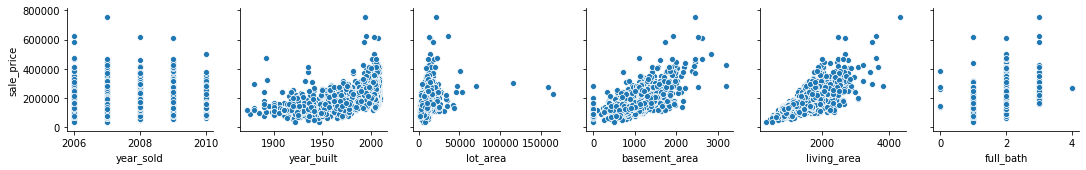

In [7]:
sns.pairplot(y_vars= ['sale_price'], x_vars=sales.columns[1:7].values, data=sales)
plt.show()

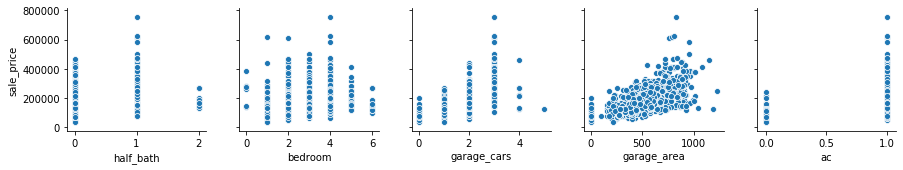

In [8]:
sns.pairplot(y_vars= ['sale_price'], x_vars=sales.columns[7:12].values, data=sales)
plt.show()

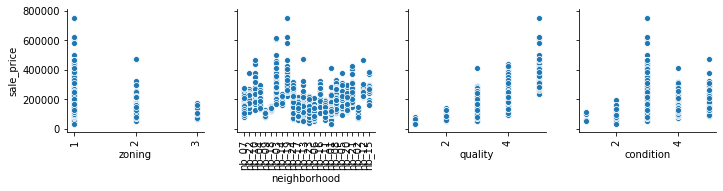

In [9]:
g = sns.pairplot(y_vars= ['sale_price'], x_vars=sales.columns[12:].values, data=sales)
g.fig.draw(
    g.fig.canvas.get_renderer()
) 
for ax in g.axes.flat: 
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

   Based on the pair plot of sales above, since the zoning data and the quality data is fairly linear, I decided to convert the categorical values into integers. Converting the categorical data into integers makes the data easier to read, but can also improve the any modelling that is preformed. Above I have created functions to convert the categorical values into integer form. I set it up so that poor correlates with 1, fair correlates with 2, average correlates with 3, good correlates with 4, and excellent correlates with 5. I also converted the zoning data into integers such that Residential_Low_Density becomes 1, Residential_Medium_Density becomes 2, and Residential_High_Density becomes 3. 

   It is clear to see that there is a linear relationship between sale price and living area, between sale price and basement area, between sale price and zoning, and between sale price and quality. 

In [10]:
sales[["neighborhood"]].describe()

,neighborhood
count,1584
unique,24
top,nb_07
freq,266


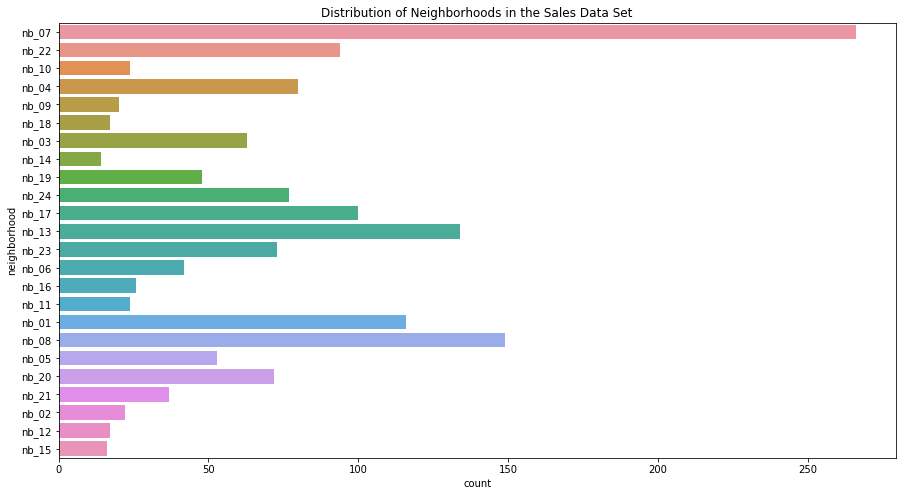

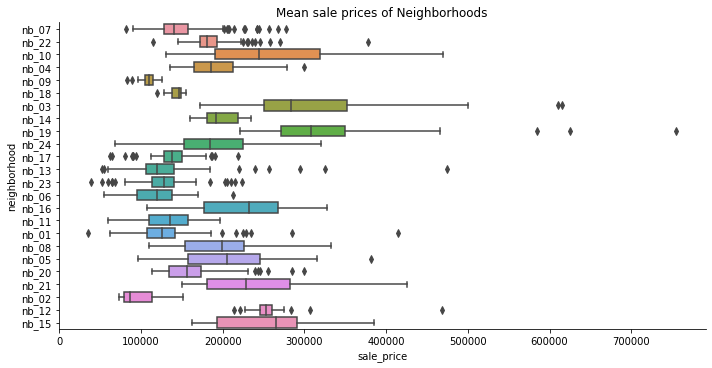

In [11]:
fig = plt.figure(figsize=(15,8))
sns.countplot(y="neighborhood", data=sales)
plt.title('Distribution of Neighborhoods in the Sales Data Set')

sns.catplot(
    x = "sale_price",
    y = "neighborhood",
    kind = "box",
    data = sales,
    aspect = 2,
)
plt.title('Mean sale prices of Neighborhoods')
plt.show()

In [12]:
sales.groupby('neighborhood')['sale_price'].mean().sort_values()

neighborhood
nb_02     97749.545455
nb_09    107822.500000
nb_06    117720.928571
nb_13    128125.216418
nb_23    128827.054795
nb_01    130021.982759
nb_11    134062.500000
nb_17    137913.080000
nb_18    141276.470588
nb_07    145952.165414
nb_20    164735.416667
nb_22    188145.276596
nb_24    190222.467532
nb_04    193079.375000
nb_08    195260.677852
nb_14    196487.500000
nb_05    208533.679245
nb_16    221934.615385
nb_21    243177.378378
nb_15    256800.000000
nb_10    263100.833333
nb_12    264454.235294
nb_03    304280.158730
nb_19    334013.708333
Name: sale_price, dtype: float64

There are 24 unique neighborhoods in the sales data set. This will cause any modelling to be very complex. Based on my analysis, I decided to split the neighborhoods into four separate regions based on their means, which are sorted above. I evenly split the neighborhoods so that each new neighborhood region contains six neighborhoods. From there I converted the neighborhood regions columns to a binary encoded form. 

In [13]:
# Splitting up the neighborhoods into 4 different groups based on their average sale price
nb_bins1 = ['nb_02', 'nb_09', 'nb_06', 'nb_13', 'nb_23', 'nb_01']
nb_bins2 = ['nb_11', 'nb_17', 'nb_18', 'nb_07', 'nb_20', 'nb_22']
nb_bins3 = ['nb_24', 'nb_04', 'nb_08', 'nb_14', 'nb_05', 'nb_16']
nb_bins4 = ['nb_21', 'nb_15', 'nb_10, ''nb_12', 'nb_03', 'nb_19']

sales.insert(13, column='nb_bin1', value= sales['neighborhood'].isin(nb_bins1).astype(int))
sales.insert(14, column='nb_bin2', value= sales['neighborhood'].isin(nb_bins2).astype(int))
sales.insert(16, column='nb_bin3', value= sales['neighborhood'].isin(nb_bins3).astype(int))
sales.insert(17, column='nb_bin4', value= sales['neighborhood'].isin(nb_bins4).astype(int))

sales = sales.drop(['neighborhood'], axis=1)

sales_test.insert(13, column='nb_bin1', value= sales_test['neighborhood'].isin(nb_bins1).astype(int))
sales_test.insert(14, column='nb_bin2', value= sales_test['neighborhood'].isin(nb_bins2).astype(int))
sales_test.insert(16, column='nb_bin3', value= sales_test['neighborhood'].isin(nb_bins3).astype(int))
sales_test.insert(17, column='nb_bin4', value= sales_test['neighborhood'].isin(nb_bins4).astype(int))

sales_test = sales_test.drop(['neighborhood'], axis=1)

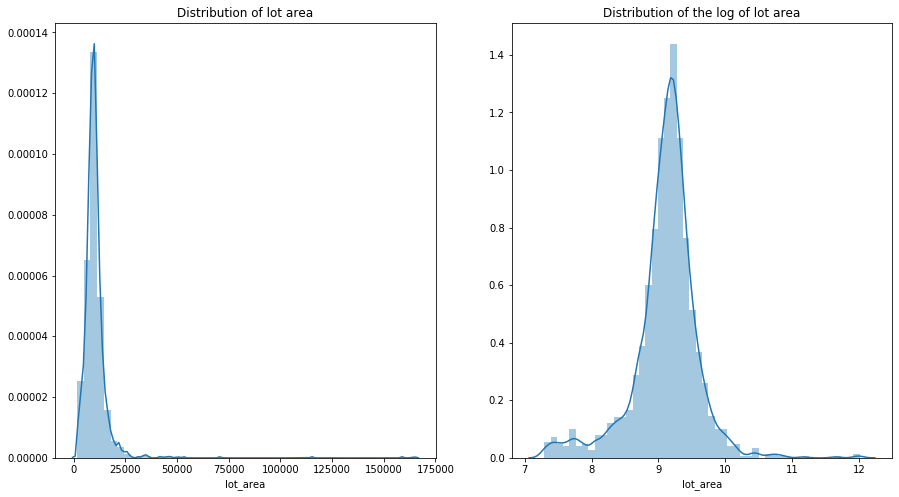

In [14]:
fig = plt.figure(figsize=(15,8))
plt.subplot(121)
sns.distplot(sales["lot_area"].dropna())
plt.title('Distribution of lot area')

plt.subplot(122)
sns.distplot(np.log(sales["lot_area"]).dropna())
plt.title('Distribution of the log of lot area')

plt.show()

The figure above on the left plotting the frequency and distribution of lot area shows that the original lot area data is positively skewed, and therefore must be transformed in some way. After testing out the logarithm function on the lot area, I found that the log of the lot area better describes the data. It is clear by the figure on the right that the log of the lot area data is no longer skewed and will therefore improve any modelling that is performed. 

In [15]:
sales[["sale_price"]].describe().round(2)

,sale_price
count,1584.00
mean,174600.29
std,72033.18
min,35000.00
25%,129000.00
50%,156225.00
75%,203033.75
max,755000.00


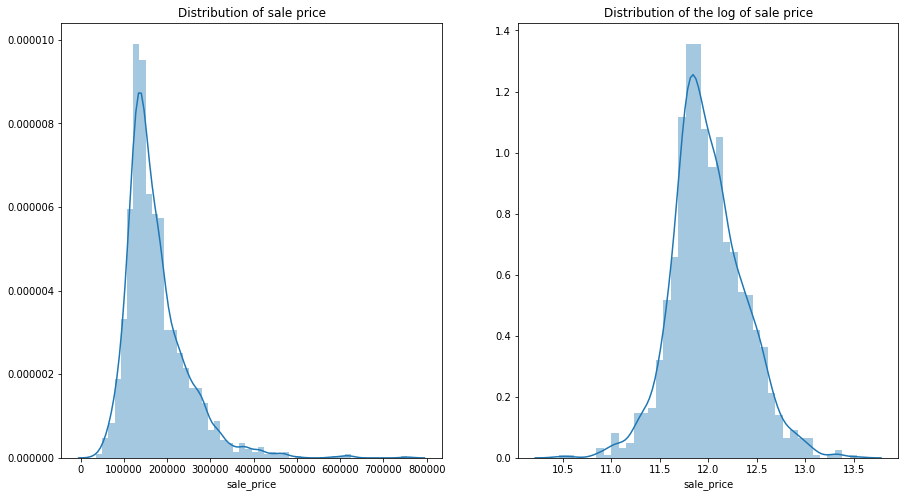

In [16]:
fig = plt.figure(figsize=(15,8))
plt.subplot(121)
sns.distplot(sales["sale_price"].dropna())
plt.title('Distribution of sale price')

plt.subplot(122)
sns.distplot(np.log(sales["sale_price"]).dropna())
plt.title('Distribution of the log of sale price')

plt.show()

The figure above plotting the frequency and distribution of the original sale price data reveals that the data is slightly positively skewed. Therefore to improve our model, we should transform the data. Based on the shape and size of the dsitribution, it's best to use the log function. Clearly the figure on the right displays that the log of the sale price data is no longer skewed and therefore will more accurately describe the data and improve any modelling that is done. 

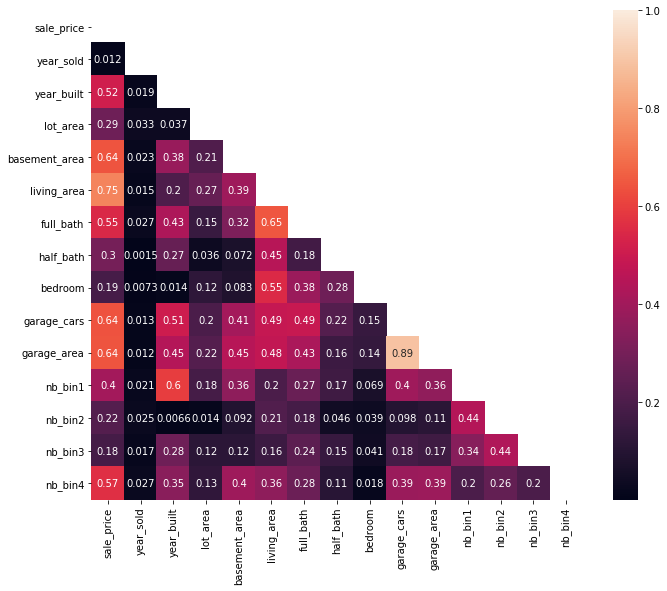

In [17]:
corr = abs(sales.corr())
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, annot=True)
plt.show()

Looking at the correlation table above, it is clear that the year sold has a very low correlation with all the other columns in the sales data table. Therefore it might be beneficial to convert the year sold and year built columns into one called age which is calculated by subtracting year built from year sold. This new column called age will correspond with the age of the house when it was last sold. 

Both half_bath and full_bath have low correlations with all the other variables in the sales data. Therefore, it might also be beneficial to combine full baths and half baths into one column called bathrooms. 

In [18]:
# Transforming the sale price of the house using the log function
sales.insert(1, column='log_sale_price', value=np.log(sales['sale_price']))
sales = sales.drop(['sale_price'], axis=1)

sales_test.insert(1, column='log_sale_price', value=np.log(sales_test['sale_price']))
sales_test = sales_test.drop(['sale_price'], axis=1)

# Transforming the lot area using the log function
sales.insert(3, column='log_lot_area', value=np.log(sales['lot_area']))
sales = sales.drop(['lot_area'], axis=1)

sales_test.insert(3, column='log_lot_area', value=np.log(sales_test['lot_area']))
sales_test = sales_test.drop(['lot_area'], axis=1)

# Calculating the age of the house when it was sold last
# Creating a new column in the sales data set called age and deleting the year built and year sold columns
sales.insert(2, column='age', value=sales['year_sold'] - sales['year_built'])
sales = sales.drop(['year_sold', 'year_built'], axis=1)

sales_test.insert(2, column='age', value=sales_test['year_sold'] - sales_test['year_built'])
sales_test = sales_test.drop(['year_sold', 'year_built'], axis=1)

# Converting full bath and half bath into one variable
sales.insert(6, column='bathrooms', value=sales['full_bath'] + sales['half_bath'])
sales = sales.drop(['full_bath'], axis=1)
sales = sales.drop(['half_bath'], axis=1)

sales_test.insert(6, column='bathrooms', value=sales_test['full_bath'] + sales_test['half_bath'])
sales_test = sales_test.drop(['full_bath'], axis=1)
sales_test = sales_test.drop(['half_bath'], axis=1)

sales.head()

,log_sale_price,age,log_lot_area,basement_area,living_area,bathrooms,bedroom,garage_cars,garage_area,ac,zoning,nb_bin1,nb_bin2,nb_bin3,nb_bin4,quality,condition
0,12.404924,42,9.320091,2110,2110,3,3,2,522,1,1,0,1,0,0,4,3
1,12.154253,13,9.534595,928,1629,3,3,2,482,1,1,0,1,0,0,3,3
2,12.162643,18,8.518193,1280,1280,2,2,2,506,1,1,0,0,0,0,4,3
3,12.373703,15,8.592115,1595,1616,2,2,2,608,1,1,0,0,0,0,4,3
4,12.149502,11,8.922658,994,1804,3,3,2,442,1,1,0,1,0,0,4,3


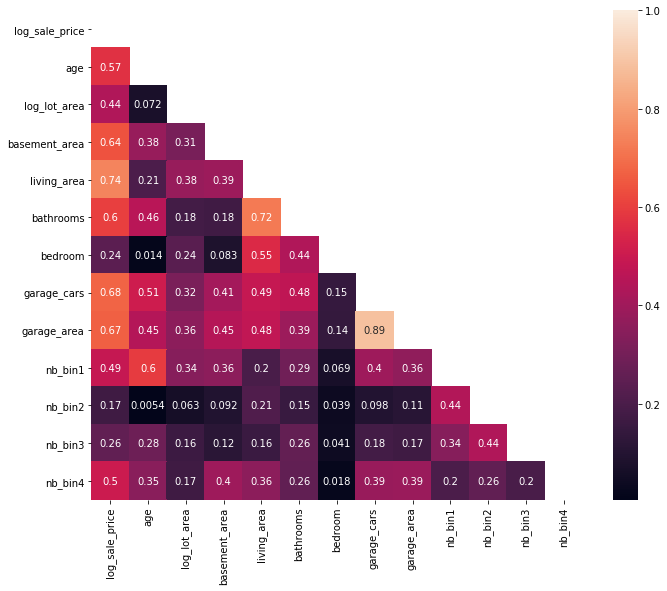

In [19]:
corr = abs(sales.corr())
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, annot=True)
plt.show()

The most important correlations that we are concerned about are the correlations between all the variables and the log of the sale price. Hence, in the figure above, we really only need to look at the first column describing the correlations between each column and the log of the sale price. 

Looking at the correlation figure above, it is clear to see that after all the preprocessing done above most of the columns are much more correlated with the log of the sale price. Most of the data is now very correlated with the log sale price. The data columns which is still only slightly correlated to the log of the sale price is the number of bedrooms and neighborhood regions two and three. 

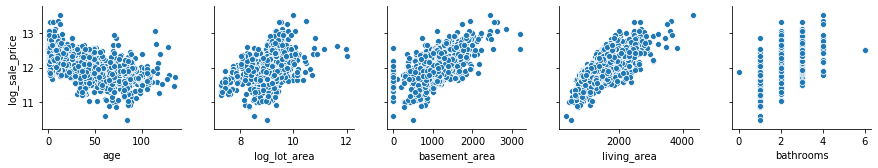

In [20]:
sns.pairplot(y_vars= ['log_sale_price'], x_vars=sales.columns[1:6].values, data=sales)
plt.show()

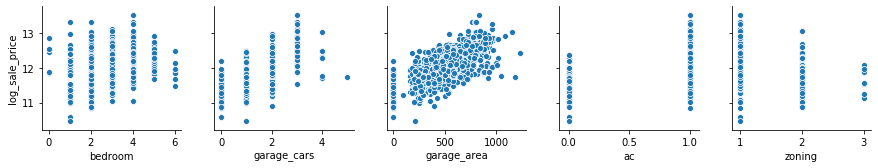

In [21]:
sns.pairplot(y_vars= ['log_sale_price'], x_vars=sales.columns[6:11].values, data=sales)
plt.show()

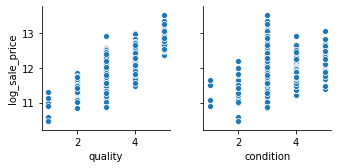

In [22]:
sns.pairplot(y_vars= ['log_sale_price'], x_vars=sales.columns[15:].values, data=sales)
plt.show()

In [23]:
sales.head()

,log_sale_price,age,log_lot_area,basement_area,living_area,bathrooms,bedroom,garage_cars,garage_area,ac,zoning,nb_bin1,nb_bin2,nb_bin3,nb_bin4,quality,condition
0,12.404924,42,9.320091,2110,2110,3,3,2,522,1,1,0,1,0,0,4,3
1,12.154253,13,9.534595,928,1629,3,3,2,482,1,1,0,1,0,0,3,3
2,12.162643,18,8.518193,1280,1280,2,2,2,506,1,1,0,0,0,0,4,3
3,12.373703,15,8.592115,1595,1616,2,2,2,608,1,1,0,0,0,0,4,3
4,12.149502,11,8.922658,994,1804,3,3,2,442,1,1,0,1,0,0,4,3


## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using.*

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. Additional code for these models shoulds be included in a supplemental materials notebook or script. What this section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.*

In [24]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

def model_fit(m, X, y, plot = False):
    """Returns the root mean squared error of a fitted model based on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    rmse = np.sqrt(mean_squared_error((y), (y_hat)))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='x', y='y', color="grey", data =  pd.DataFrame(data={'x': [min(y),max(y)], 'y': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Fit plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y', y='resid', data=res).set_title("Residual plot")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model rmse = " + str(round(rmse, 4)), fontsize=16)
        plt.show()
    
    return rmse

In [25]:
# Training data
Xt = sales.drop(['log_sale_price'], axis=1)
yt = sales.log_sale_price

print('Xt:', Xt.shape)
print('yt:', yt.shape)

# Validation data
Xv = sales_test.drop('log_sale_price', axis=1)
yv = sales_test.log_sale_price

print('Xv:', Xv.shape)
print('yv:', yv.shape)

# Complete data
complete = pd.concat([sales, sales_test])
X = complete.drop(['log_sale_price'], axis=1)
y = complete.log_sale_price

print('X:', X.shape)
print('y:', y.shape)

Xt: (1584, 16)
yt: (1584,)
Xv: (350, 16)
yv: (350,)
X: (1934, 16)
y: (1934,)


In [26]:
# Scaled linear regression
S = StandardScaler().fit(X)
Xt_scaled = S.transform(Xt)
Xv_scaled = S.transform(Xv)

### Ridge Regression Model

In [28]:
# Finding the best alpha for Ridge Regression
r_cv = RidgeCV(
    alphas = np.linspace(0.1, 20, num=200), # RidgeCV does not allow alpha=0 for some reason
    scoring = "neg_mean_squared_error"
).fit(Xt_scaled, yt)

print('The best alpha for the ridge regression model is {0}'.format(r_cv.alpha_))
print('Coefficients: {0}'.format(r_cv.coef_))

The best alpha for the ridge regression model is 3.8
Coefficients: [-0.07600451  0.04291401  0.06260509  0.15545848  0.00465875 -0.03115786
  0.02851663  0.01391942  0.02486341 -0.01029562 -0.05938668 -0.04696789
 -0.03068369 -0.00355066  0.07101734  0.05961621]


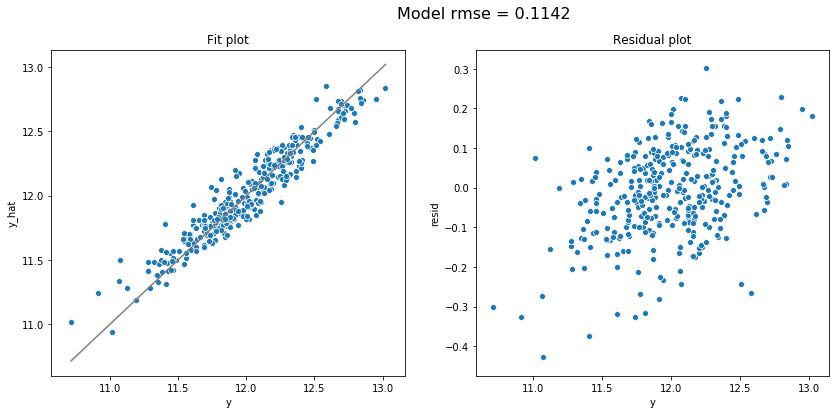

0.11423010991380354

In [29]:
model_fit(r_cv, Xv_scaled, yv, plot=True)

alpha: 2.6
Coefficients: [-0.07622032  0.04293463  0.06251459  0.15591645  0.00438301 -0.03125246
  0.02853507  0.01378404  0.0248533  -0.01025751 -0.06022295 -0.04784549
 -0.03149352 -0.00413204  0.07090066  0.05970896]


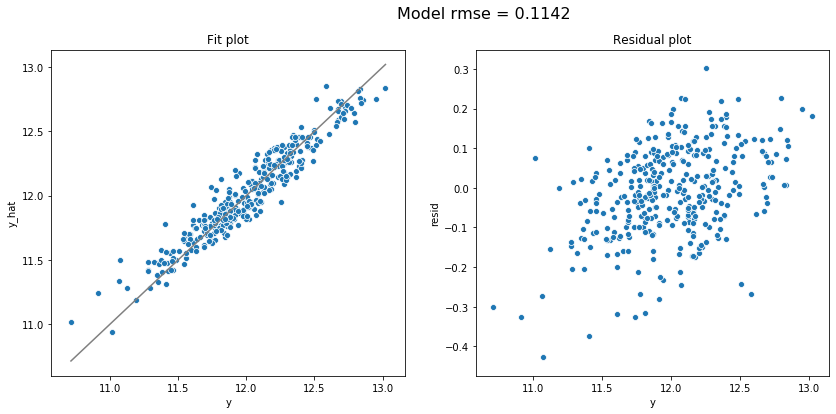

rmse: 0.11420870421102178
[-0.07622032  0.04293463  0.06251459  0.15591645  0.00438301 -0.03125246
  0.02853507  0.01378404  0.0248533  -0.01025751 -0.06022295 -0.04784549
 -0.03149352 -0.00413204  0.07090066  0.05970896]


In [30]:
# Ridge Regression using the K-fold method
r_cv2 = RidgeCV(
    alphas=np.linspace(0.1, 20, num=200), 
    cv=KFold(5, True, random_state=1234),
    scoring = "neg_mean_squared_error"
).fit(Xt_scaled, yt)

print( "alpha:", r_cv2.alpha_)
print('Coefficients: {0}'.format(r_cv2.coef_))
print( "rmse:", model_fit(r_cv2, Xv_scaled, yv, plot=True) )
print(r_cv2.coef_)

In [31]:
sales_testc = sales_test.copy()
sales_testc['predict_sales'] = np.exp(r_cv.predict(Xv_scaled))
print('The negative root mean squared error in terms of US dollars is {0}.'.format(np.sqrt(mean_squared_error(np.exp(sales_testc.log_sale_price), sales_testc.predict_sales))))


The negative root mean squared error in terms of US dollars is 20936.25944002915.


My ridge regression model takes the scaled sales data and trains the model on the scaled training data. Xt_scaled is the scaled training data without the log of the sale price data. yt is the training data for the log of the sale price. While I trained my ridge regression model on the scaled training data, I tested the model using the sales_test data and renamed the pre-processed sales test data as Xv_scaled and yv where Xv is all features minus the log of the sale price and yv is the test log of the sale price data. 

After training my model and testing it on the test data I found that the negative root mean squared error in log terms is 0.114. The negative root mean squared error in terms on US dollars is $ 20,936.26. 

## 4. Discussion


*In this section you should provide a general overview of your final model and its performance. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant. The target audience for this should be someone who is familiar with the basics of real estate and mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. Your goal should be to convince this audience that your model is both accurate and useful.*

The Ridge Regression model was the most accurate model and the model with the lowest root mean squared error. Ridge Regression is a variation of the linear regression model. It introduces an $\ell_2$ penalty on the coefficients to a standard least squares problem. Mathematically, the ridge regression model can be expressed as

$$ \underset{\boldsymbol{\beta}}{\text{argmin}} \; \lVert \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta} \rVert^2 + \alpha (\boldsymbol{\beta}^T\boldsymbol{\beta}) $$ 

In my analysis, I found that ridge regression was the best model. I trained and tested many different models such as Lasso, Linear Regression, and Regression Trees so that I could compare them with my ridge regression model. All the code testing the various other models I thought might work really well are in the appendix of this file. While regression trees and Lasso were not very accurate, linear regression and ridge regression had a very similar negative root mean squared error. In the table below, I have the calculated root mean squared errors for each model that I trained and tested. 

Model             | RMSE     
------------------|----------
Linear Regression | 0.11416
Ridge Regression  | 0.11420
Lasso             | 0.12410
Regression Trees  | 0.15982

It is clear to see that the regression tree had a much larger rmse compared with the other models that I tested. The lasso method has a low rmse which is fairly close to the ridge regression and linear regression models, but the best alpha that I found for the lasso using grid search was 0.1. This causes the model to be fairly linear and not differ very much from linear regression. Therefore both linear regression and ridge regression are better models than the lasso method and regression trees. 

When comparing linear regression with ridge regression, linear regression is not a very complex method and therefore will not be as consistent when prediciting future housing sale prices. The coefficients of the linear regression model is:

$ [-2.637e-03, 8.741e-02, 1.511e-04, 3.179e-04, 4.7178e-03, -3.886e-02, 3.922e-02, 6.758e-05, 1.009e-01, -2.545e-02, -1.426e-01, -1.0432e-01, -7.609e-02 -1.772e-02, 1.1957e-01, 1.163e-01] $

Whereas the coefficients for my ridge regression model is:

$ [-0.07622032,  0.04293463,  0.06251459,  0.15591645,  0.00438301, -0.03125246,
  0.02853507,  0.01378404,  0.0248533,  -0.01025751, -0.06022295, -0.04784549,
 -0.03149352, -0.00413204,  0.07090066,  0.05970896] $

The coefficients above are assoicated with the columns: 

age, log lot area, basement_area, living_area, bathrooms, bedroom, garage cars, garage area, ac, zoning, nb bin1, nb bin2, nb bin3, nb bin4, quality, condition.

The larger the coefficients the better, more accurate and consistent the model is. It is clear to see that the coefficients of the ridge regression model are much better than the coefficients associated with the linear regression model. Therefore when comparing the coefficients, the ridge regression model is more accurate and therefore more useful. 

It is clear to see that the living area had the most influence on the ridge regression model for predicting future housing sale prices. 

Overall, the ridge regression model is the most accurate model based on the sales data features available. It performs well and the prediction is off by $ 20,936.26.

## 5. Model Validation

*We have provided a third csv file called `sales_holdout.csv` which we will be using for assessing the predictive performance of your model. The file provided with the assignment contains **identical** data to `sales_test.csv`, however after you turn in your notebook we will be replacing this file with the true holdout data (350 additional house sales not included in the train or test set) and rerunning your notebook.*

*The objective of this is two-fold, the first is to ensure that your modeling code is reproducible and everything can be rerun and "identical" results can be obtained. And second, to obtain a reliable estimate of your final model's predictive performance, which will be compared across all of the projects in the course.*

*You should include a brief write up in the section detailing the performance of your model, in particular you should discuss the implications of this modeling uncertainty in the context of predicting house prices. For example, buyers and sellers are likely to care if the prediction is off by `$20,000` but are less likely to care if it is off by `$500`.*

In [32]:
sales_holdout = pd.read_csv("sales_holdout.csv")

rat_to_int('quality', sales_holdout)
rat_to_int('condition', sales_holdout)
zone_to_int('zoning', sales_holdout)
ac_to_bin('ac', sales_holdout)

sales_holdout.insert(13, column='nb_bin1', value= sales_holdout['neighborhood'].isin(nb_bins1).astype(int))
sales_holdout.insert(14, column='nb_bin2', value= sales_holdout['neighborhood'].isin(nb_bins2).astype(int))
sales_holdout.insert(16, column='nb_bin3', value= sales_holdout['neighborhood'].isin(nb_bins3).astype(int))
sales_holdout.insert(17, column='nb_bin4', value= sales_holdout['neighborhood'].isin(nb_bins4).astype(int))
sales_holdout = sales_holdout.drop(['neighborhood'], axis=1)

sales_holdout.insert(1, column='log_sale_price', value=np.log(sales_holdout['sale_price']))
sales_holdout = sales_holdout.drop(['sale_price'], axis=1)

sales_holdout.insert(3, column='log_lot_area', value=np.log(sales_holdout['lot_area']))
sales_holdout = sales_holdout.drop(['lot_area'], axis=1)

sales_holdout.insert(2, column='age', value=sales_holdout['year_sold'] - sales_holdout['year_built'])
sales_holdout = sales_holdout.drop(['year_sold', 'year_built'], axis=1)

sales_holdout.insert(6, column='bathrooms', value=sales_holdout['full_bath'] + sales_holdout['half_bath'])
sales_holdout = sales_holdout.drop(['full_bath'], axis=1)
sales_holdout = sales_holdout.drop(['half_bath'], axis=1)

X_holdout = sales_holdout.drop('log_sale_price', axis=1)
y_holdout = sales_holdout.log_sale_price

In [33]:
# Complete data
complete = pd.concat([sales, sales_test, sales_holdout])
X_com = complete.drop(['log_sale_price'], axis=1)
y_com = complete.log_sale_price

[ 1.19994086e+01 -7.56220411e-02  4.59087384e-02  6.04077818e-02
  1.59218016e-01  2.96654011e-03 -3.18917641e-02  2.75567109e-02
  1.26581017e-02  2.72387024e-02 -1.14515200e-02 -6.50052750e-02
 -5.17328104e-02 -3.47374278e-02 -3.97994856e-03  6.98632273e-02
  5.91545686e-02]


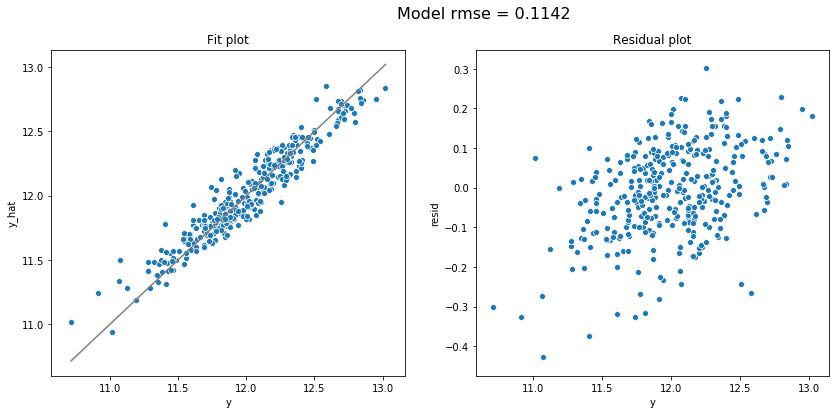

0.11423010991380354

In [34]:
# Scaled linear regression
S = StandardScaler().fit(X)
X_scaled = S.transform(X)
Xh_scaled = S.transform(X_holdout)
lm_scaled = LinearRegression().fit(X_scaled, y)

print(get_coefs(lm_scaled))

model_fit(r_cv, Xh_scaled, y_holdout, plot=True)

In [35]:
sales_holdoutc = sales_holdout.copy()
sales_holdoutc['predict_sales'] = np.exp(r_cv.predict(Xh_scaled))
print('The negative root mean squared error in terms of US dollars is {0}.'.format(np.sqrt(mean_squared_error(np.exp(sales_holdoutc.log_sale_price), sales_holdoutc.predict_sales))))


The negative root mean squared error in terms of US dollars is 20936.25944002915.


After analyzing the ridge regression model with the new holdout data, the prediction of housing sale prices is off by $\$20,936.25$. Although this seems like a large amount of money, overall the average sale price of a house is about $\$200,000$ and if the prediction is off by $\$20,000$, then this is only 10 $ \%$ of the sale price. Being off by 10 $\%$ is insignificant when you are talking about a very large sum of money. 

There are other issues with this model. Although one of the features is the year the house was built and the year the house was sold, it does not take into account the housing market at that time. The model does not take into account if the housing market is really high or really low. 

Overall, I believe my model is quite useful in predicting housing sale prices. 

## Appendix

### 3.1 Linear Regression

Coefficients: [-2.63743771e-03  8.74109843e-02  1.51177724e-04  3.17946875e-04
  4.71780723e-03 -3.88600705e-02  3.92273115e-02  6.75881580e-05
  1.00995838e-01 -2.54546108e-02 -1.42680017e-01 -1.04329585e-01
 -7.60924864e-02 -1.77203887e-02  1.19571963e-01  1.16311309e-01]


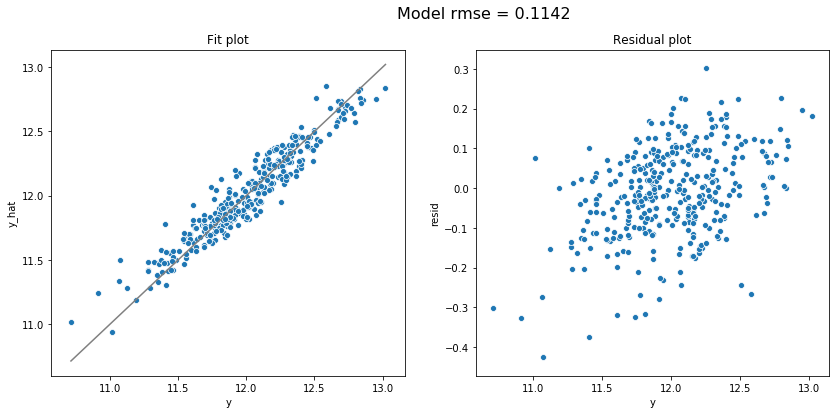

0.1141644034762155

In [36]:
lr = LinearRegression().fit(Xt, yt)
print('Coefficients: {0}'.format(lr.coef_))
model_fit(lr, Xv, yv, plot=True)

In [37]:
sales_testc = sales_test.copy()
sales_testc['predict_sales'] = np.exp(lr.predict(Xv))
np.sqrt(mean_squared_error(np.exp(sales_testc.log_sale_price), sales_testc.predict_sales))

20935.810885558374

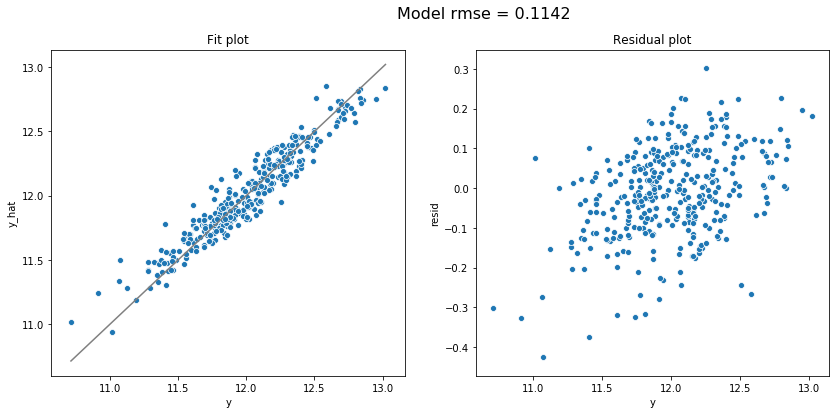

0.1141644034762168

In [38]:
# Scaled Linear Regression

lm_scaled = LinearRegression().fit(Xt_scaled, yt)
get_coefs(lm_scaled)

model_fit(lm_scaled, Xv_scaled, yv, plot=True)

### 3.4 Lasso

In [39]:
alphas = np.linspace(0.01, 1, num=100)

l_gs = GridSearchCV(
    Lasso(),
    param_grid={'alpha': alphas},
    cv=KFold(5, True, random_state=1234),
    scoring="neg_mean_squared_error"
).fit(Xt_scaled, yt)

print( "best alpha:", l_gs.best_params_['alpha'])
print( "best rmse :", np.exp(np.sqrt(l_gs.best_score_ * -1)))
print( "validation rmse:", model_fit(l_gs.best_estimator_, Xv_scaled, yv))

best alpha: 0.01
best rmse : 1.1258295255098838
validation rmse: 0.12165343221748252


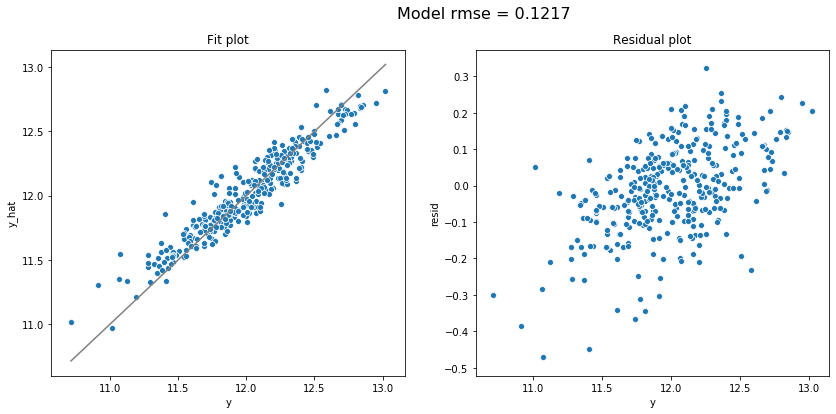

lasso rmse: 0.12165343221748252
lasso coefs: [ 1.20012992e+01 -7.33822397e-02  3.70998003e-02  6.23324571e-02
  1.42028948e-01  0.00000000e+00 -1.16064633e-02  2.74121362e-02
  1.77050966e-02  1.89164743e-02 -4.55207073e-03 -2.05538382e-02
 -1.82722108e-03  0.00000000e+00  1.38409462e-02  8.11147436e-02
  4.49096629e-02]


In [40]:
l = Lasso(alpha=0.01).fit(Xt_scaled, yt)
print("lasso rmse:", model_fit(l, Xv_scaled, yv, plot=True))
print("lasso coefs:", get_coefs(l))

### 3.5 Cross Validation

In [41]:
m = make_pipeline(
    PolynomialFeatures(degree=1),
    LinearRegression(fit_intercept=False)
)

cv = np.sqrt(-cross_val_score(m, Xt, yt, cv=5, scoring="neg_mean_squared_error"))

print(cv)
print(cv.mean())

[0.11264541 0.11454999 0.10615344 0.11106687 0.12346453]
0.11357604937592489


In [42]:
# 5-fold cross validation
cv = np.sqrt(-cross_val_score(m, X, y, cv=5, scoring="neg_mean_squared_error"))

print(cv)
print(cv.mean())

[0.10833037 0.11840836 0.10608103 0.12112697 0.11602832]
0.11399501169901868


alpha: 3.8


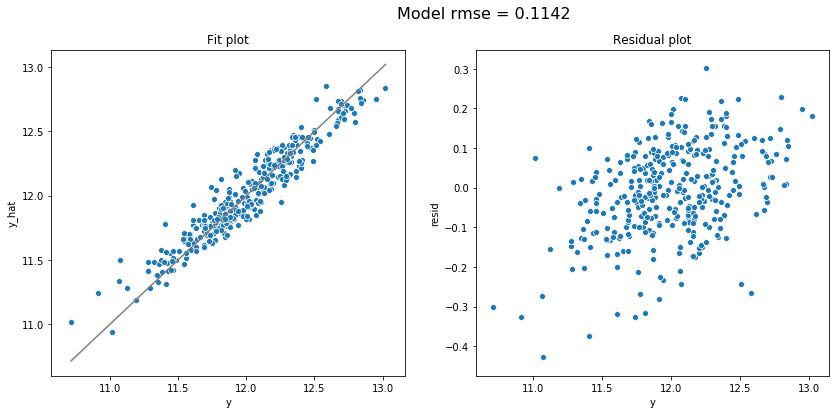

rmse: 0.11423010991380354


In [43]:
# Tuning with Ridge CV
from sklearn.linear_model import RidgeCV

r_cv = RidgeCV(
    alphas = np.linspace(0.1, 20, num=200),
    scoring = "neg_mean_squared_error"
).fit(Xt_scaled, yt)

print( "alpha:", r_cv.alpha_)
print( "rmse:", model_fit(r_cv, Xv_scaled, yv, plot=True) )

### 3.7 Regression Trees

In [44]:
T_gs = GridSearchCV(
    DecisionTreeRegressor(),
    param_grid={'max_depth': np.arange(1, 15),
               'min_samples_leaf': np.arange(1,15)},
#                'max_leaf_nodes': np.arange(2,20)},
    cv=KFold(5, True, random_state=1234),
    scoring="neg_mean_squared_error"
).fit(Xt, yt)

print( "max depth:", T_gs.best_params_['max_depth'])
print( "min samples leaf:", T_gs.best_params_['min_samples_leaf'])
# print( "max leaf nodes:", T_gs.best_params_['max_leaf_nodes'])

max depth: 12
min samples leaf: 14


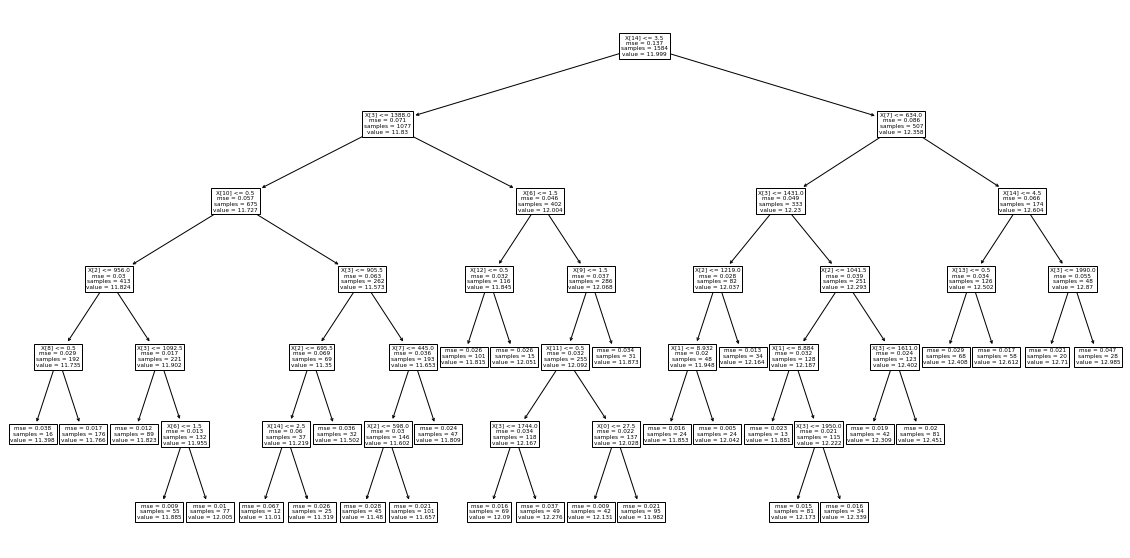

In [45]:
regressor = DecisionTreeRegressor(criterion='mse', max_depth=10, min_samples_leaf=12, max_leaf_nodes=30)
reg_tree = regressor.fit(Xt, yt)

fig = plt.figure(figsize=(20,10))
sklearn.tree.plot_tree(reg_tree)
plt.show()

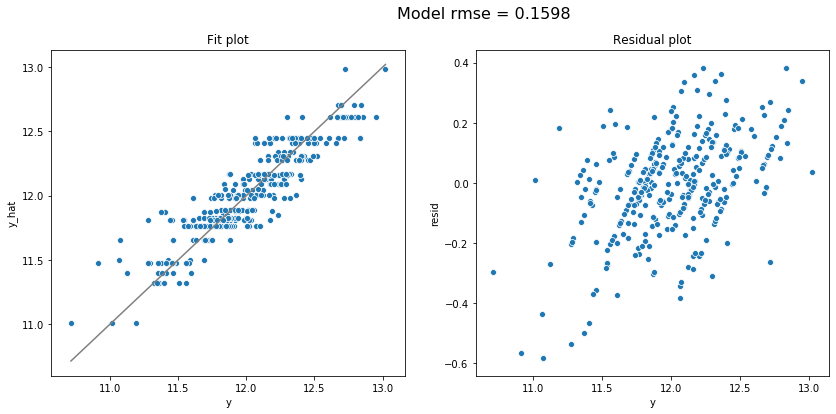

0.1598233481251339

In [46]:
model_fit(reg_tree, Xv, yv, plot=True)